## 1. Presentaci√≥n

En el presente notebook se realiza la extracci√≥n de informaci√≥n de tweets relacionados con el usuario *TheBridge_Tech*, con el fin de analizar y evaluar los sentimientos con respecto al perfil de la escuela a trav√©s de un an√°lisis de datos exploratorio y en funci√≥n de esa extracci√≥n y con un modelo preentrenado, sacar conclusiones y posteriormente proceder a su despliegue en la web.

### 1. Recopilar los **tweets**

In [ ]:
#%pip install git+https://github.com/JustAnotherArchivist/snscrape.git

#actualizar librer√≠a snscrape. viene por defecto una desactualizada y hay que hacerlo de forma manual

In [27]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import plotly.express as px
import plotly.figure_factory as ff
import sklearn
import warnings #para ignorar advertencias

#importar librer√≠as necesarias

In [22]:
#definimos el usuario a buscar y el rango de fechas para los par√°metros
account = "@TheBridge_Tech"
start_date = "2023-02-13"
end_date = "2023-05-22"

#crear la query
query = f"{account} since:{start_date} until:{end_date}"

#obtener tweets con bucle
tweets = []
for tweet in sntwitter.TwitterSearchScraper(query).get_items():
    tweet_id = tweet.id
    text = tweet.rawContent
    date = tweet.date.strftime('%Y-%m-%d %H:%M:%S')
    author_id = tweet.user.id
    author_name = tweet.user.displayname
    author_username = tweet.user.username
    retweets = tweet.retweetCount
    replies = tweet.replyCount
    likes = tweet.likeCount
    quotes = tweet.quoteCount
    

    tweets.append([tweet_id, text, date, author_id, author_name, author_username, retweets, replies, likes, quotes])

    #romper el bucle cuando alcance un exceso de tweets
    if len(tweets) >= 200:
        break

Stopping after 20 empty pages


In [23]:
#crear el dataframe a partir de los datos que se solicitan
columns = ["ID", "Text", "Date", "Author ID", "Author Name", "Author Username", "Retweets", "Replies", "Likes", "Quotes"]
tweets_df = pd.DataFrame(tweets, columns=columns)

In [4]:
#visualizamos el df
tweets_df.head()

ID                                               Text   
0  1659514560200470559  Ayer visitamos a los alumnos de @TheBridge_Tec...  \
1  1659136842854219776  ¬øQu√© hac√≠an nuestros alumni antes del #bootcam...   
2  1658825158994403329  #MLMonitoring and #Observability, mar, 23 may ...   
3  1658791064306688002  Nos colamos en el campus de #Bilbao para descu...   
4  1658430987368386566  As√≠ es el¬†#bootcamp¬†de¬†#UXUIProductDesign¬†que ...   

                  Date            Author ID           Author Name   
0  2023-05-19 11:01:18            987047282                 A3Sec  \
1  2023-05-18 10:00:23  1162694149956603904            The Bridge   
2  2023-05-17 13:21:52             41545659  Mario Lopez de Avila   
3  2023-05-17 11:06:23  1162694149956603904            The Bridge   
4  2023-05-16 11:15:34  1162694149956603904            The Bridge   

  Author Username  Retweets  Replies  Likes  Quotes  
0           a3sec         1        0      3       1  
1  TheBridge_Tech         0        0      0       0  
2    nodosenlared         1        0      3       0  
3  TheBridge_Tech         1        0      2       0  
4  TheBridge_Tech         1        0      3       0

In [7]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               143 non-null    int64 
 1   Text             143 non-null    object
 2   Date             143 non-null    object
 3   Author ID        143 non-null    int64 
 4   Author Name      143 non-null    object
 5   Author Username  143 non-null    object
 6   Retweets         143 non-null    int64 
 7   Replies          143 non-null    int64 
 8   Likes            143 non-null    int64 
 9   Quotes           143 non-null    int64 
dtypes: int64(6), object(4)
memory usage: 11.3+ KB


In [8]:
tweets_df.describe()

ID     Author ID    Retweets     Replies       Likes   
count  1.430000e+02  1.430000e+02  143.000000  143.000000  143.000000  \
mean   1.640923e+18  7.433382e+17    1.468531    0.349650    3.510490   
std    9.297728e+15  5.770250e+17    2.666443    0.674054    4.871398   
min    1.625127e+18  7.154412e+06    0.000000    0.000000    0.000000   
25%    1.634147e+18  1.003872e+09    0.000000    0.000000    1.000000   
50%    1.638579e+18  9.365398e+17    1.000000    0.000000    2.000000   
75%    1.648301e+18  1.162694e+18    2.000000    1.000000    4.000000   
max    1.659515e+18  1.613114e+18   25.000000    4.000000   39.000000   

           Quotes  
count  143.000000  
mean     0.153846  
std      0.521478  
min      0.000000  
25%      0.000000  
50%      0.000000  
75%      0.000000  
max      4.000000

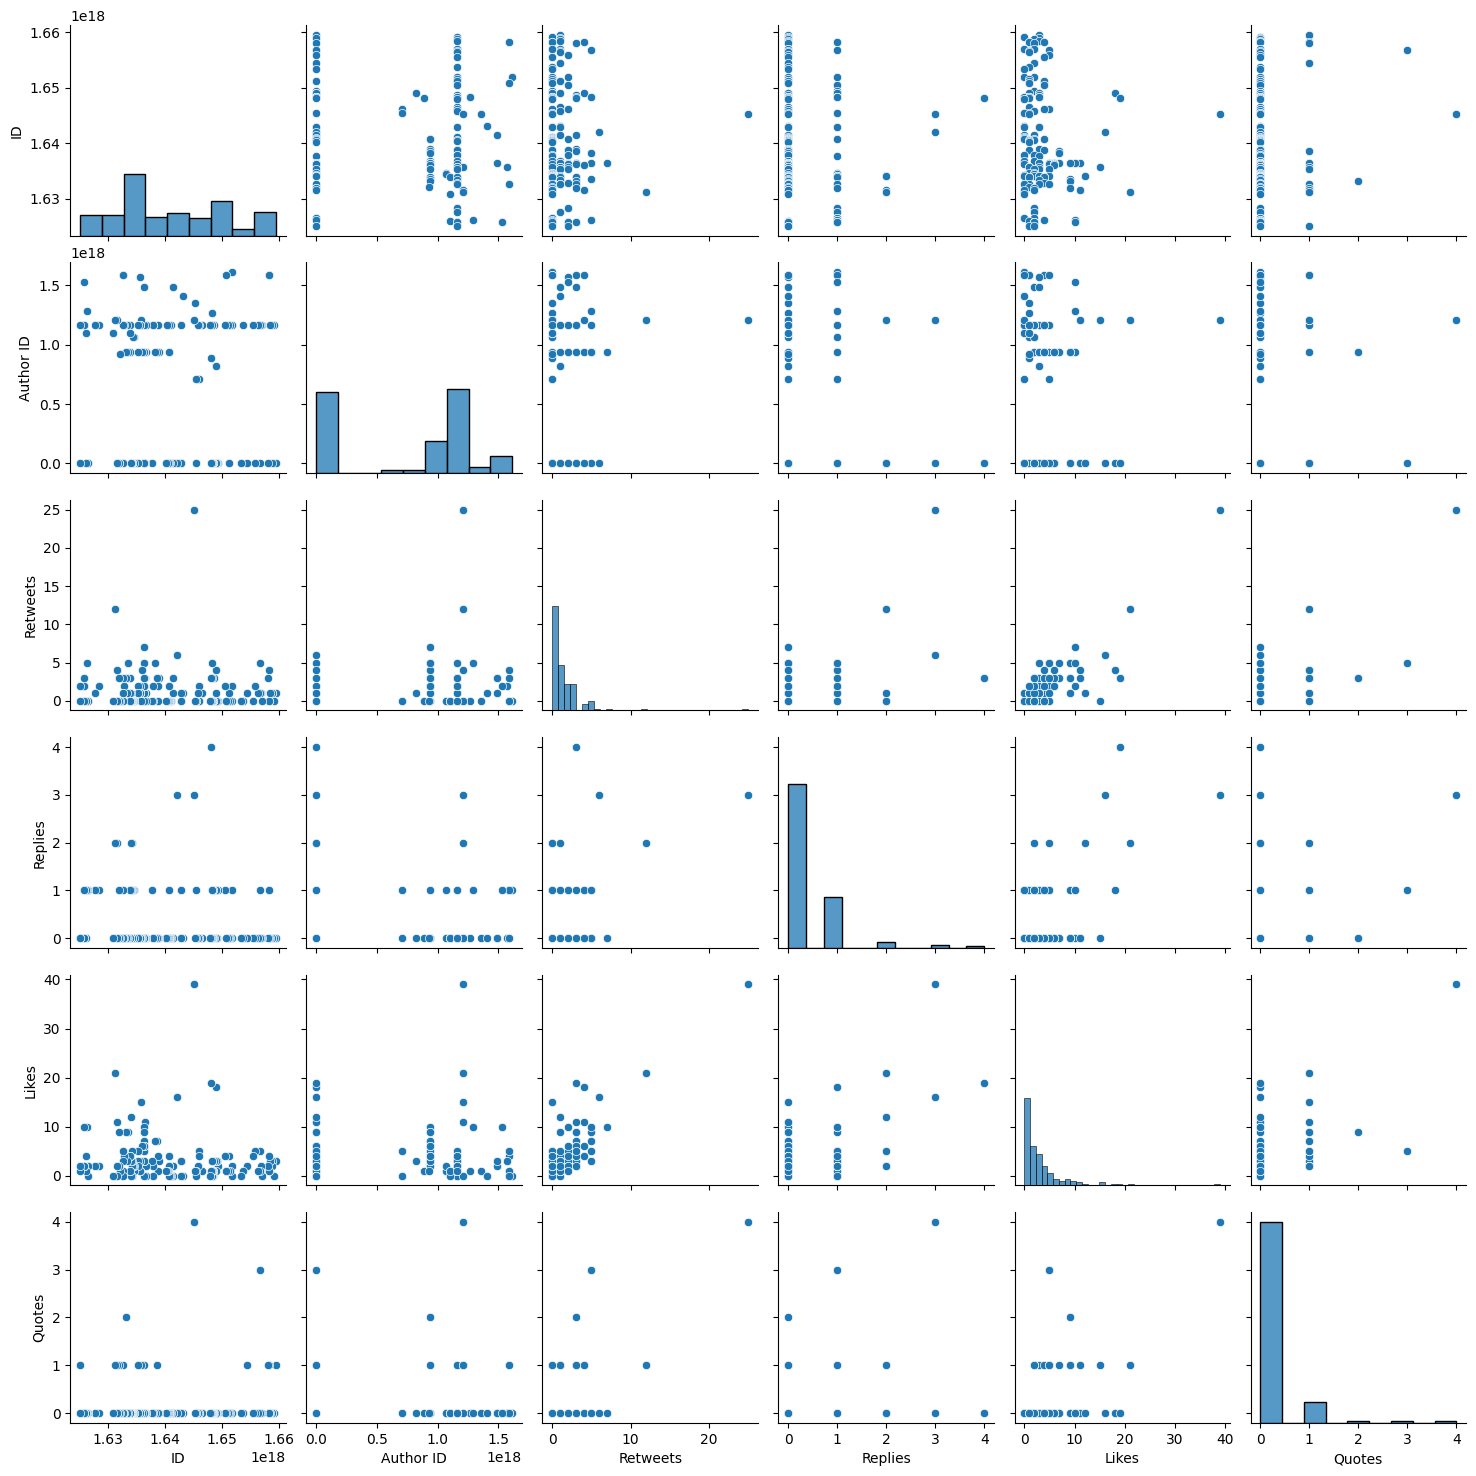

In [9]:
sns.pairplot(tweets_df);
#no hay una relaci√≥n entre las variables

### 2. Base de datos SQL

In [5]:
#primero creo mi base de datos y le doy nombre
conn = sqlite3.connect('tuiterdb.db')

In [20]:
#creo el cursor para ejecutar los comandos
cursor = conn.cursor()

In [21]:
#tabla 1 ¬∑ usuarios
cursor.execute('''
    CREATE TABLE usuarios (
        id INTEGER,
        nombre TEXT,
        nombre_usuario TEXT
    )
''')

In [22]:
#tabla 2 ¬∑ tweets
cursor.execute('''
    CREATE TABLE tweets (
        id INTEGER PRIMARY KEY,
        contenido TEXT,
        fecha_publicacion TEXT,
        usuario_id INTEGER,
        retweets INTEGER,
        replies INTEGER,
        likes INTEGER,
        quotes INTEGER,
        FOREIGN KEY (usuario_id) REFERENCES usuarios (id)
    )
''')

In [23]:
#bucle para llenar mis 2 tablas de mi database con los datos de mi dataframe
for _, row in tweets_df.iterrows():
    tweet_data = [
        row['ID'],
        row['Text'],
        row['Date'],
        row['Author ID'],
        row['Retweets'],
        row['Replies'],
        row['Likes'],
        row['Quotes']
    ]
    author_data = [
        row['Author ID'],
        row['Author Name'],
        row['Author Username']
    ]

    cursor.execute('INSERT INTO tweets VALUES (?, ?, ?, ?, ?, ?, ?, ?)', tweet_data)
    cursor.execute('INSERT INTO usuarios VALUES (?, ?, ?)', author_data)

In [6]:
#guardar y cerrar
conn.commit()
conn.close()

### 3. An√°lisis de datos exploratorio

3.1-    En primer lugar analizaremos el tweet con mayor repercusi√≥n social en el rango de fechas comprendido entre 13-febrero y 22-mayo de este mismo a√±o (2023):

In [29]:
tweets_df.Retweets.max()
#accedemos al n√∫mero m√°s alto de retweets que podamos encontrar en el df

25

In [33]:
#hacemos lo mismo con likes, replies y quotes para mirar cu√°les son los que han tenido m√°s interacciones
print('El tweet con mayor n√∫mero de respuestas, tiene: ',tweets_df.Replies.max(),'respuestas')
print('El tweet con mayor n√∫mero de likes, tiene: ',tweets_df.Likes.max(),'likes')
print('El tweet con mayor n√∫mero de citas, tiene: ',tweets_df.Quotes.max(),'citas')

El tweet con mayor n√∫mero de respuestas, tiene:  4 respuestas
El tweet con mayor n√∫mero de likes, tiene:  39 likes
El tweet con mayor n√∫mero de citas, tiene:  4 citas


In [36]:
#buscamos los tuits que cumplen con las m√©tricas que tenemos de los n√∫meros m√°s altos

tweets_df[(tweets_df.Retweets == 25) | (tweets_df.Replies == 4) | (tweets_df.Likes == 39) | (tweets_df.Quotes == 4)]

ID                                               Text   
42  1648038694387871801  Untagged Day - El evento de anal√≠tica digital ...  \
51  1645201576217157637  Para reactivarse!!!\nTenemos Meetup este marte...   

                   Date            Author ID        Author Name   
42  2023-04-17 19:00:18             20979418    I√±aki Gorostiza  \
51  2023-04-09 23:06:36  1207228796593745920  Decentralized ‚Çø‰∏∞‚ö°   

    Author Username  Retweets  Replies  Likes  Quotes  
42     hello_google         3        4     19       0  
51  decentralized_b        25        3     39       4

Observamos que hay dos tweets con buena repercusi√≥n, pero sin duda es el segundo el que ha obtenido m√°s interacciones por parte de los usuarios. El tweet dice: 

In [38]:
tweets_df['Text'].iloc[51]

'Para reactivarse!!!\nTenemos Meetup este martes 11 de abril a las 19:00 en @TheBridge_Tech\n\n@dev7ba nos hablar√° sobre la mempool!!\nCharla para todo el mundo, sepas o no sobre #Bitcoin \n\n@GaboHBeaumont @kilrau @libertariadora @olya_borderless\nhttps://t.co/bHzpDduIRo\n\nSe agradece RT'

Habla de una charla sobre criptomonedas en Abril, que tuvo bastante buena aceptaci√≥n

3.2 - Vamos a buscar ahora cu√°l es el usuario que m√°s menciona a la escuela:

In [39]:
tweets_df['Author Username'].value_counts()

Author Username
TheBridge_Tech     45
DatabeerSVQ        17
nodosenlared        9
ESOLIUPO            6
decentralized_b     5
ToniDorta           4
espacio_RES         4
hello_google        4
PauMugarra          4
turoninos           3
my_tech_plan        3
Godivaciones        3
milmadrid_          2
libertariadora      2
alexaom6_           2
carlosmdh           2
vizca75             2
joobid              2
Metricool_es        2
jorgegrev           2
EDEMempresarios     2
MISTERINCGNITA1     2
RoccoLozano         1
detailorg           1
rperezmarco         1
Recuenco            1
42UrdulizFTef       1
a3sec               1
Delachica           1
luismesalas         1
Cyber_Madrid        1
gzuuus              1
UbaldoHervas        1
AlejoPietraSEO      1
BBKnetwork          1
ProductoActual1     1
Madrid4Refugees     1
BitcoinTuesday_     1
Name: count, dtype: int64

Observamos que el que m√°s se menciona es la misma escuela, probablemente en funci√≥n de respuestas a tweets en los que ha sido mencionado y al responder, se responde a s√≠ mismo para mantener intacto el hilo de respuestas y que cualquiera pueda seguirlas de una forma ordenada. 

El usuario inmediatamente siguiente que m√°s interact√∫a con la escuela es **DatabeerSVQ**. Vamos a ver sus tweets:

In [40]:
tweets_df[tweets_df['Author Username'] == 'DatabeerSVQ']

ID                                               Text   
62   1640759403455426560  ¬°En 5 minutos abrimos las puertas de @sngular ...  \
63   1640743327145291777  El jueves pasado disfrutamos mucho de la edici...   
68   1638948723483975680  ¬°Que ya estamos preparando la cervecita fresqu...   
71   1638578785963606016  ¬°Qu√© ganas de #DatabeerSVQ19! Ya est√° aqu√≠ a p...   
72   1638212188832759808  #Dataholics, este jueves #DatabeerSVQ19, con c...   
76   1636774407862353920  #Dataholic, ¬øconoces a nuestros colaboradores?...   
79   1636422407480066050  @jrtexeira, co-fundador de @MagmaSevilla, nos ...   
80   1636421459831603216  Pedro Albarrac√≠n, Data Scientist, nos hablar√° ...   
81   1636420575735296000  Sergio Soto, Software Engineer, nos hablar√° de...   
82   1636419888754442242  Emilio Fuentes, analista en CNMC, nos contar√° ...   
83   1636418703528017945  ¬°Presentamos cartel√≥n para #DatabeerSVQ19! Nos...   
90   1636053394287632387  Ya estamos enfriando cervezas...üçª y preparando...   
96   1635332396118851584  ¬°Ya huele a primavera #dataholic! Recuerda que...   
109  1633882844232839177  Recuerda que coincidiendo con la llegada de la...   
110  1633880326735790091  #Dataholic, ¬øconoces a nuestros patrocinadores...   
114  1633512915885072386  ¬°Hola #Dataholics! Recuerda que tenemos abiert...   
116  1633154604018876416  ¬°Hola #dataholics! La primavera trompetera se ...   

                    Date           Author ID  Author Name Author Username   
62   2023-03-28 16:55:00  936539844079218688  DatabeerSVQ     DatabeerSVQ  \
63   2023-03-28 15:51:07  936539844079218688  DatabeerSVQ     DatabeerSVQ   
68   2023-03-23 17:00:00  936539844079218688  DatabeerSVQ     DatabeerSVQ   
71   2023-03-22 16:30:00  936539844079218688  DatabeerSVQ     DatabeerSVQ   
72   2023-03-21 16:13:16  936539844079218688  DatabeerSVQ     DatabeerSVQ   
76   2023-03-17 17:00:03  936539844079218688  DatabeerSVQ     DatabeerSVQ   
79   2023-03-16 17:41:19  936539844079218688  DatabeerSVQ     DatabeerSVQ   
80   2023-03-16 17:37:33  936539844079218688  DatabeerSVQ     DatabeerSVQ   
81   2023-03-16 17:34:03  936539844079218688  DatabeerSVQ     DatabeerSVQ   
82   2023-03-16 17:31:19  936539844079218688  DatabeerSVQ     DatabeerSVQ   
83   2023-03-16 17:26:36  936539844079218688  DatabeerSVQ     DatabeerSVQ   
90   2023-03-15 17:15:00  936539844079218688  DatabeerSVQ     DatabeerSVQ   
96   2023-03-13 17:30:00  936539844079218688  DatabeerSVQ     DatabeerSVQ   
109  2023-03-09 17:30:00  936539844079218688  DatabeerSVQ     DatabeerSVQ   
110  2023-03-09 17:20:00  936539844079218688  DatabeerSVQ     DatabeerSVQ   
114  2023-03-08 17:00:03  936539844079218688  DatabeerSVQ     DatabeerSVQ   
116  2023-03-07 17:16:14  936539844079218688  DatabeerSVQ     DatabeerSVQ   

     Retweets  Replies  Likes  Quotes  
62          0        1      2       0  
63          2        0      4       0  
68          3        0      3       0  
71          3        0      7       1  
72          5        0      7       0  
76          1        0      2       0  
79          2        0      3       0  
80          3        0      7       0  
81          5        0      5       0  
82          3        0      6       0  
83          7        0     10       0  
90          4        0      6       0  
96          2        0      3       0  
109         3        0      4       0  
110         3        0      4       0  
114         5        0      9       0  
116         3        0      9       2

Como podemos observar, la mayor√≠a de tweets hacen alusi√≥n a las colaboraciones que hacen la escuela y la organizaci√≥n a la hora de montar eventos unidos para charlar sobre la disciplina de Data Science al mismo tiempo que tomar alg√∫n refrigerio, estos se encuentran espec√≠ficamente en la capital andaluza. 

3.3 - Los meses en los que se concentra la mayor actividad de menciones y comunicaci√≥n con respecto a la escuela los sacaremos ahora mismo: 

In [42]:
tweets_df['Date'].dtype
#primero comprobamos su tipo y la convertimos a datetime

dtype('O')

In [47]:
tweets_df['Date'] = pd.to_datetime(tweets_df['Date'], format="%Y-%m-%d %H:%M:%S")
#comprobamos el tipo
tweets_df['Date'].dtype

dtype('<M8[ns]')

In [48]:
tweets_df['Date'].dt.month.value_counts()
#aqu√≠ comprobamos cu√°ntas veces aparecen tweets seg√∫n el mes

Date
3    73
4    38
5    19
2    13
Name: count, dtype: int64

Como podemos observar, el mes en el que ha habido mayor interacciones con la escuela ha sido justo tras empezar el intake del a√±o 2023, en el mes de marzo. Despu√©s han ido decayendo las comunicaciones por esta red social en el resto de meses, lo graficamos: 

In [ ]:
#guardamos en una variable el conteo de los meses
counts = tweets_df['Date'].dt.month.value_counts()

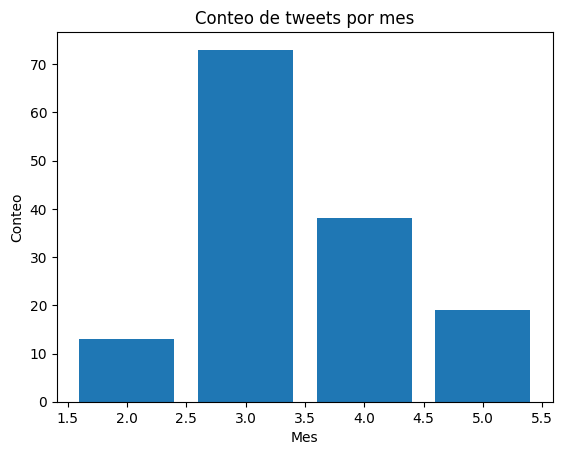

In [59]:
#creamos la gr√°fica
plt.bar(counts.index, counts.values);

plt.xlabel('Mes')
plt.ylabel('Conteo')
plt.title('Conteo de tweets por mes')

plt.show()

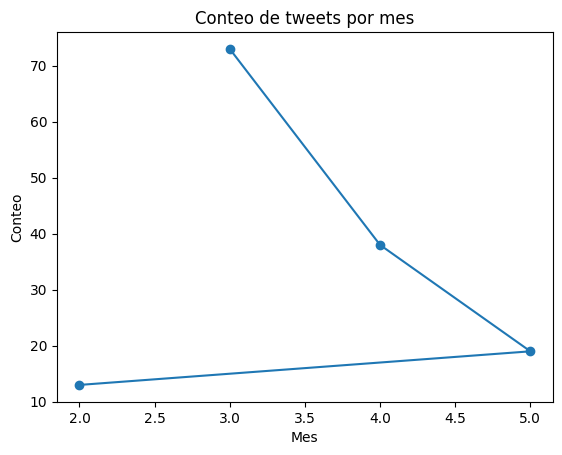

In [61]:
#gr√°fico de l√≠neas
plt.plot(counts.index, counts.values, marker='o')

plt.xlabel('Mes')
plt.ylabel('Conteo')
plt.title('Conteo de tweets por mes')

plt.show()

3.4 - Otro de los factores importantes a analizar es cu√°les son las palabras m√°s utilizadas a la hora de revisar los tweets que se dirigen hacia la escuela y sus menciones, esto nos puede dar informaci√≥n relevante sobre el sentimiento de los usuarios hacia la marca:

In [66]:
palabras_contadas = []

#bucle para almacenar las palabras en mi lista vac√≠a 

for tweet in tweets_df['Text']:
    palabras = tweet.split()
    conteo = Counter(palabras)
    palabras_contadas.extend(conteo.items())

#ordenar la lista por orden para ver las m√°s habituales
palabras_contadas = sorted(palabras_contadas, key=lambda x: x[1], reverse=True)

In [69]:
palabras_contadas

[('a', 5),
 ('de', 5),
 ('de', 4),
 ('üëâ', 4),
 ('de', 4),
 ('de', 4),
 ('de', 4),
 ('la', 4),
 ('el', 4),
 ('a', 4),
 ('por', 4),
 ('en', 4),
 ('de', 4),
 ('de', 3),
 ('de', 3),
 ('de', 3),
 ('de', 3),
 ('&amp;', 3),
 ('de', 3),
 ('en', 3),
 ('en', 3),
 ('de', 3),
 ('en', 3),
 ('de', 3),
 ('y', 3),
 ('de', 3),
 ('de', 3),
 ('y', 3),
 ('el', 3),
 ('en', 3),
 ('el', 3),
 ('la', 3),
 ('en', 3),
 ('el', 3),
 ('el', 3),
 ('de', 3),
 ('en', 3),
 ('de', 3),
 ('de', 3),
 ('de', 3),
 ('de', 3),
 ('the', 3),
 ('la', 3),
 ('de', 3),
 ('de', 3),
 ('a', 3),
 ('a', 3),
 ('de', 3),
 ('de', 3),
 ('lo', 3),
 ('que', 3),
 ('la', 3),
 ('y', 3),
 ('en', 3),
 ('de', 3),
 ('en', 3),
 ('de', 3),
 ('de', 3),
 ('un', 3),
 ('en', 2),
 ('y', 2),
 ('el', 2),
 ('de', 2),
 ('su', 2),
 ('en', 2),
 ('y', 2),
 ('el', 2),
 ('en', 2),
 ('qu√©', 2),
 ('de', 2),
 ('y', 2),
 ('de', 2),
 ('y', 2),
 ('Entradas', 2),
 ('at', 2),
 ('a', 2),
 ('en', 2),
 ('en', 2),
 ('y', 2),
 ('y', 2),
 ('con', 2),
 ('las', 2),
 ('lo', 2),


Como vemos las palabras m√°s empleadas no son ninguna en especial, en su mayor√≠a conectores, nexos y determinantes que funcionan para dar sentido a las oraciones, pero no hay una palabra muy utilizada como tal que nos d√© informaci√≥n espec√≠fica.

3.5.- Vamos a centrarnos en las m√©tricas de los tweets y a buscar correlaci√≥n matem√°tica entre ellas: 

In [17]:
#en primer lugar sacamos una matriz de correlaci√≥n del dataframe sobre una tabla
correlation_matrix = tweets_df[['Likes', 'Retweets', 'Quotes', 'Replies']].corr()

A continuaci√≥n observamos las correlaciones matem√°ticas que hay entre las m√©tricas de los tweets, como sabemos, la correlaci√≥n s√≥lo mide la relaci√≥n lineal entre las variables y no implica causalidad. 

In [18]:
correlation_matrix

Likes  Retweets    Quotes   Replies
Likes     1.000000  0.822879  0.572948  0.530167
Retweets  0.822879  1.000000  0.631514  0.358802
Quotes    0.572948  0.631514  1.000000  0.246580
Replies   0.530167  0.358802  0.246580  1.000000

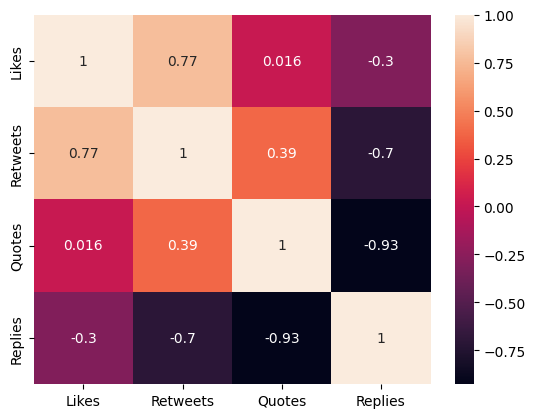

In [20]:
sns.heatmap(correlation_matrix.corr(), annot=True);

Lo que podemos observar es una buena correlaci√≥n entre **Retweets** y **Likes**, lo que entendemos por el uso de la plataforma habitual es que los perfiles que dan me gusta, suelen adem√°s compartir el contenido a sus propios seguidores con un *retweet*, como una forma de certificar de doble forma que una publicaci√≥n determinada ha sido de su agrado. 


In [47]:
#hacemos un heatmap interactivo con plotly
fig = px.imshow(correlation_matrix)
fig.write_html('correlation_plotly.html')

Otra de las relaciones que llama la atenci√≥n es la que sucede entre las citas (*quotes*) y las respuestas a los tweets. Cuando un usuario cita el tweet, lo comparte al mismo tiempo que puede hacer un comentario sobre el contenido en su propio perfil, por lo que citando se ahorra responder al usuario de la publicaci√≥n original de forma directa, sino que lo comparte directamente como parte de su *timeline*. 

In [48]:
#haremos un scatterplot interactivo con plotly
columns = ['Likes', 'Retweets', 'Quotes', 'Replies']

fig = ff.create_scatterplotmatrix(tweets_df[columns], diag='histogram', height=800, width=800)
fig.write_html('scatter_plotly.html')

Aunque hemos sacado bastantes datos analizando nuestras m√©tricas, a√∫n se puede exprimir algo m√°s:

In [4]:
#para seguir analizando, separamos las columnas de las m√©tricas en una variable
metrics = tweets_df.iloc[:, 6:10]

In [32]:
#lo metemos en un propio df que re√∫ne una suma de los valores
metrics_df = {
    'retw_sum' : [metrics['Retweets'].sum()],
    'rep_sum' : [metrics['Replies'].sum()],
    'like_sum' :[ metrics['Likes'].sum()],
    'quot_sum' : [metrics['Quotes'].sum()],
    'tweets_sum' : [len(tweets_df)]
}

metrics_df = pd.DataFrame(metrics_df)

In [34]:
metrics_df

retw_sum  rep_sum  like_sum  quot_sum  tweets_sum
0       210       50       503        22         143

Con esto lo que observamos es la tendencia de los usuarios a dar *like* por encima de cualquier otra m√©trica, incluso doblando la siguiente que tiene por debajo, el *retweet*. Los usuarios prefieren hacer una interacci√≥n directa con el perfil que proporciona el contenido, antes que compartirlo con el resto de los seguidores de sus propios perfiles (con un *retweet* o un *quote*). 


Vemos que las respuestas son un n√∫mero bastante bajo cuando hablamos de un total de 140 tweets dirigidos a la escuela. En cambio el n√∫mero de *likes* y de *retweets* tiene unas cifras atractivas, puesto que partiendo de un an√°lisis de 143 publicaciones (entre 13/02 y 22/05) que mencionan a **@TheBridge_Tech**, obtenemos algo m√°s de **1.4 RT / Tweet publicado**, mientras que son **3.5 MG / Tweet publicado** para la escuela.

### 4. Pre-trained model

In [ ]:
#!C:\Users\lcasa\Documents\THE BRIDGE - DATA SCIENCE 2023\Alumno\Entregas m√≥dulos\4.- Data Engineering\myenv\Scripts\python.exe

In [7]:
import pickle

In [28]:
#abrimos el modelo pre-entrenado

with open ('./model/sentiment_model', 'rb') as file:
    sentiment_model = pickle.load(file)

c:\Users\lcasa\Documents\THE BRIDGE - DATA SCIENCE 2023\Alumno\Entregas m√≥dulos\4.- Data Engineering\myenv\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator CountVectorizer from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\lcasa\Documents\THE BRIDGE - DATA SCIENCE 2023\Alumno\Entregas m√≥dulos\4.- Data Engineering\myenv\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\lcasa\Documents\THE BRIDGE - DATA SCIENCE 2023\Alumno\Entr

In [30]:
#hacemos las predicciones de sentimiento con el modelo
tweets_df['sentiment'] = sentiment_model.predict(tweets_df['Text'])

In [32]:
#revisamos si la data est√° balanceada y cu√°les son los valores que nos da
tweets_df['sentiment'].value_counts()

sentiment
0    80
1    63
Name: count, dtype: int64

Con esto podemos pensar que, bas√°ndonos s√≥lo en sentimientos negativos y positivos y quitando los neutrales o medios, el sentimiento generalizado en las menciones a **@TheBridge_Tech** es negativo. Ahora vamos a revisar que el modelo est√© en lo cierto:

In [35]:
len(tweets_df[tweets_df['Author Name'] == 'The Bridge'])

45

Para ajustar un poco m√°s la limpieza y los resultados del *sentiment analysis*, decidimos retirar del dataframe las publicaciones que tienen como autor al mismo The Bridge, en las que la misma escuela se menciona, o bien por verse envuelta en una serie de hilos de respuesta, o bien para darse publicidad a s√≠ misma. Con esto queremos comprobar que el sentimiento hacia la marca no es m√°s negativo sino positivo por parte del p√∫blico, alumnos y aquellos no pertenecientes a la misma escuela.

In [37]:
#creamos de nuevo el df quitando aquellos en los que el autor es el propio The Bridge
tweets_wo_TB = tweets_df[tweets_df['Author Name'] != 'The Bridge']

In [38]:
#volvemos a entrenar el modelo
tweets_wo_TB['sentiment'] = sentiment_model.predict(tweets_wo_TB['Text'])

In [39]:
tweets_wo_TB['sentiment'].value_counts()

sentiment
0    54
1    44
Name: count, dtype: int64

No obtenemos una diferencia grande, lo que vemos es que hay una diferencia de unos diez puntos entre la polaridad negativa/positiva. Vamos a analizar en profundidad qu√© interpretamos con cada valor 0/1. 

In [50]:
sentiment_model

Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.5, max_features=1000, min_df=5,
                                 ngram_range=(1, 2))),
                ('cls', LogisticRegression(C=0.5))])

In [54]:
#sacamos los hiperpar√°metros con los que ha trabajado nuestro modelo para ver c√≥mo est√° funcionando
sentiment_model.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(max_df=0.5, max_features=1000, min_df=5, ngram_range=(1, 2))),
  ('cls', LogisticRegression(C=0.5))],
 'verbose': False,
 'vect': CountVectorizer(max_df=0.5, max_features=1000, min_df=5, ngram_range=(1, 2)),
 'cls': LogisticRegression(C=0.5),
 'vect__analyzer': 'word',
 'vect__binary': False,
 'vect__decode_error': 'strict',
 'vect__dtype': numpy.int64,
 'vect__encoding': 'utf-8',
 'vect__input': 'content',
 'vect__lowercase': True,
 'vect__max_df': 0.5,
 'vect__max_features': 1000,
 'vect__min_df': 5,
 'vect__ngram_range': (1, 2),
 'vect__preprocessor': None,
 'vect__stop_words': None,
 'vect__strip_accents': None,
 'vect__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vect__tokenizer': None,
 'vect__vocabulary': None,
 'cls__C': 0.5,
 'cls__class_weight': None,
 'cls__dual': False,
 'cls__fit_intercept': True,
 'cls__intercept_scaling': 1,
 'cls__l1_ratio': None,
 'cls__max_iter': 100,
 'cls__multi_class': 'auto',
 'cls__n_jobs': None,


In [63]:
predictions_rev = pd.concat([tweets_df['sentiment'],tweets_df['Text']], axis=1)

In [64]:
#aqu√≠ revisamos los tweets con su polaridad con mayor claridad
predictions_rev = pd.DataFrame(predictions_rev)

In [78]:
#as√≠ visualizamos todo el df para poder leer el texto correctamente
pd.set_option('max_colwidth', 800)

In [80]:
#vamos a ver los que ser√≠an positivos considerando 1 = True (positivo)
predictions_rev[predictions_rev['sentiment'] == 1]

sentiment                                                                                                                                                                                                                                                                                                                   Text
0            1                        Ayer visitamos a los alumnos de @TheBridge_Tech  para charlar con ellos sobre las capacidades en prevenci√≥n y detecci√≥n de #ciberseguridad de @a3sec  y compartir experiencias que les puedan ayudar en su incorporaci√≥n al mundo laboral.\n¬°Gracias por la invitaci√≥n! https://t.co/r1YVULrSOl
2            1                 #MLMonitoring and #Observability, mar, 23 may 2023, 18:30   | Meetup https://t.co/VEq7ZN3Plr\n¬°2¬∫ encuentro de la @mlopscommunity en @TheBridge_Tech ! Acomp√°√±anos para aprender de nuestros amigos de @wayflyerapp @wallapop @argilla_io Registro gratuito, plazas limitadas. https://t.co/Zw5bKGP0av
6            1                                                                                                                                Si todav√≠a no has pillado las entradas (que son gratis oye, que es posible gracias a partners como @TheBridge_Tech üòé) puedes hacerlo en https://t.co/EeZ3fSC7PP https://t.co/hTvRME7aeR
8            1                    #MLMonitoring and #Observability, mar, 23 may 2023, 18:30   | Meetup https://t.co/B0hKnfFg5g\n¬°2¬∫ encuentro de la @mlopscommunity en @TheBridge_Tech ! Acomp√°√±anos para aprender de nuestros amigos de @wayflyerapp @wallapop @argilla Registro gratuito, plazas limitadas. https://t.co/t0TiFALbfl
12           1   Llega Work in Tech, una iniciativa de INCO Academy con la que @TheBridge_Tech colabora junto a @Googleorg y @coursera.\n\nFormaci√≥n en tecnolog√≠a dirigida a personas en situaci√≥n vulnerable.\n\nüí∞Formaci√≥n 100% financiada.\nüíªOnline.\nüíºCareer Readiness.\n\n Infoüëâhttps://t.co/7wflIafygE https://t.co/jCHs3HBRrI
..         ...                                                                                                                                                                                                                                                                                                                    ...
134          1       .@EstiLeon, Responsable del campus #42UrdulizFTef ya se encuentra participando de la mesa redonda - "Nuevos formatos en la formaci√≥n" del @workinlansummit!\n\nCompartimos mesa con BBK Bootcamps by \n@TheBridge_Tech, IED KunsthalBilbao y @BBK_eus\n \n#WORKinlan #Bizkaia #Educaci√≥n https://t.co/Iu6ZYqlFLz
135          1                              Buenos d√≠as CPSers!\nHoy podemos confirmar que el tercer meetup de la comunidad #CPS en Madrid ser√° en @TheBridge_Tech. Agradecemos enormemente la generosidad de este espacio, y os esperamos el mi√©rcoles que viene!\n\nP.D: A√∫n quedan unas pocas plazas, est√°is a tiempo de apuntaros
137          1              ¬øTe animas a crear un videojuego con programaci√≥n? üéÆ ¬°Ven al taller de #desarrollowebfullstack en Sevilla!\n\nDesarrollaremos juntos un videojuego usando un poco de #JavaScript y #Canvas\n\nüìÜ2 mar\n‚è∞18.00h\nüìçCampus @ENCamaraSevilla\n\n¬°Ap√∫ntate ya! üëâhttps://t.co/sO7cjQNX3A https://t.co/1AeD5EBmeT
138          1    ¬øLos colores tienen g√©nero?¬øpodemos hacer una app destinada a mujeres sin caer en estereotipos?\n\nPara contestar a todo esto, presentamos la charla ‚ÄúLa perspectiva de g√©nero en el dise√±o UX‚Äù ¬°No te lo pierdas!\n\nüìÜ23 feb\n‚è∞18.00h\nüíªOnline\n\n¬°Inscr√≠bete ya! üëâhttps://t.co/18K0xxRZUn https://t.co/VBjXQrD34t
142          1  Les compartimos un mini resumen del 1¬∫ encuentro de #reinventadxs\n\nY anunciamos que entramos en la cuenta regresiva del 2¬∫, ap√∫ntate esta fecha: 30 de marzo.\n\n¬øTe vemos en #Madrid?\n\nGracias a @thebridge_tech y el @milmadrid_ por hacerlo posible y nos vemos pronto!\n\n#mytechplan https://t.co/z5fwZzNR5w

[63 ro

In [81]:
#sacamos las de sentimiento negativo, considerando que 0 == False (negativo)
predictions_rev[predictions_rev['sentiment'] == 0]

sentiment                                                                                                                                                                                                                                                                                                                    Text
1            0  ¬øQu√© hac√≠an nuestros alumni antes del #bootcamp?\n\nAs√≠ fue el Open Day de #Sevilla donde compartieron su experiencia, dudas, miedos y sus ganas de hacer un cambio en su carrera üöÄ\n\n¬øReady para el cambio?\n\n¬°√öltimas plazas!üëâhttps://t.co/4DRdoJhQqv\n\n@camaradesevilla @ENCamaraSevilla https://t.co/6VJRsx67Fx
3            0               Nos colamos en el campus de #Bilbao para descubrir m√°s sobre #BBKBootcampsPoweredByTheBridge üòç\n\nEcha un üëÄ a las clases y al buen ambiente lleno de c√≥digo javascript, dise√±os en figma y librer√≠as de python üêç\n\n¬°Nueva edici√≥n 22 de mayo! ‚û°https://t.co/dUXyyvMX8F\n@BBK_eus https://t.co/YoZy5dGASo
4            0              As√≠ es el¬†#bootcamp¬†de¬†#UXUIProductDesign¬†que impartimos junto a¬†@EDEMempresarios en #Valencia.\n\nMiriam, Lead Instructor, nos cuenta qu√© se ense√±a en el programa de #uxui y qu√© salidas profesionales tiene este campo üöÄ\n\nPr√≥xima edici√≥n 22 de mayo ‚û°https://t.co/kqfZqnITa1 https://t.co/HLJKIpkMta
5            0                            Y finalmente, como nos dec√≠an en casa, es de bien nacido ser agradecido, y mucho m√°s con nuestros patrocinadores y colaboradores ü§óü§ó. Gracias a @TheBridge_Tech @epsUPO @pablodeolavide por ayudarnos, de una manera u otra, para que esta actividad salga adelante!! https://t.co/m8IeCD9prx
7            0                                                                                                                                                               ¬°¬°Recuerda que todav√≠a siguen las entradas para el II CyberSec Talks!! Dentro breve hilo\n@TheBridge_Tech @epsUPO @pablodeolavide https://t.co/ua2XS32Iph
..         ...                                                                                                                                                                                                                                                                                                                     ...
133          0                                                                                                         @42UrdulizFTef @EstiLeon @workinlansummit @TheBridge_Tech @BBK_eus Hoy finaliza #WORKinlan y lo hace ya con una buena participaci√≥n en Twitter y eso que a√∫n queda todo el d√≠a de hoy üí™ https://t.co/54lcCbyUGi
136          0                                                                                                                                                                                                                                                                    @TheBridge_Tech @Vacolba @andresmacariog interesante
139          0                                                                                                                                                                                                                                                                                            @BitcoinTuesday_ ¬°Un placer!
140          0                                                                                                                    Gracias a nuestros amigos @TheBridge_Tech por acogernos ayer en una manera bastante flexible, ten√©is el equipo m√°s adorable de todo Madrid! ‚ô•Ô∏è\n\nFue genial pasar San Valent√≠n hablando #Bitcoin  üôè
141          0      ¬°Nos vamos al WorkinLan Workshop en Bilbao junto a @BBK_eus !ü§©\n\nLos d√≠as 16 y 17 de febrero impartiremos talleres de UX/UI, Data, ponencias sobre nuevos empleos y podr√°s ponerte a prueba con nuestro TechSkilling Proba.\n\n¬°Inscr√≠bete ya!üëâ https://t.co/4DDrV2k2VR\n\n #bbkbootcamps https://t.co/XCMlcPJ

In [82]:
sentiment_model.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(max_df=0.5, max_features=1000, min_df=5, ngram_range=(1, 2))),
  ('cls', LogisticRegression(C=0.5))],
 'verbose': False,
 'vect': CountVectorizer(max_df=0.5, max_features=1000, min_df=5, ngram_range=(1, 2)),
 'cls': LogisticRegression(C=0.5),
 'vect__analyzer': 'word',
 'vect__binary': False,
 'vect__decode_error': 'strict',
 'vect__dtype': numpy.int64,
 'vect__encoding': 'utf-8',
 'vect__input': 'content',
 'vect__lowercase': True,
 'vect__max_df': 0.5,
 'vect__max_features': 1000,
 'vect__min_df': 5,
 'vect__ngram_range': (1, 2),
 'vect__preprocessor': None,
 'vect__stop_words': None,
 'vect__strip_accents': None,
 'vect__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vect__tokenizer': None,
 'vect__vocabulary': None,
 'cls__C': 0.5,
 'cls__class_weight': None,
 'cls__dual': False,
 'cls__fit_intercept': True,
 'cls__intercept_scaling': 1,
 'cls__l1_ratio': None,
 'cls__max_iter': 100,
 'cls__multi_class': 'auto',
 'cls__n_jobs': None,


In [84]:
sentiment_model.get_feature_names_out

<bound method Pipeline.get_feature_names_out of Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.5, max_features=1000, min_df=5,
                                 ngram_range=(1, 2))),
                ('cls', LogisticRegression(C=0.5))])>

No sacamos en claro una polaridad real en ninguno de los *tweets* que podemos leer en nuestros dataframes. No podemos observar una tendencia hacia un sentimiento u otro, pero s√≠ podr√≠amos entender por qu√© ha categorizado algunas de las publicaciones entre cada uno de los polos. Si revisamos de nuevo los hiperpar√°metros que ha tenido en cuenta el modelo, podemos observar que ha utilizado un *Logistic Regression* muy b√°sico, con un rango de n-gramas de dos m√°x., y se han basado √∫nicamente en analizar las palabras de la variable TEXT y cada dos palabras en conjunto. 

En este modelo se pod√≠an haber tenido en cuenta los propios emojis, e incluso los caracteres especiales que se emplean para enfatizar o no sobre la sentencia. Lo que es seguro es que el sentimiento generalizado es positivo e incluso cari√±oso y meloso con respecto a la escuela desde sus invitados y alumnos y otras colaboraciones. El modelo deber√≠a analizar mucho mejor uniendo por mayor cantidad de palabras, habr√≠a sido √≥ptima alguna t√©cnica de procesamiento de texto como Spacy y un modelo m√°s complejo como una red neuronal. La mayor√≠a de los *tweets* deber√≠an representar el mismo d√≠gito en binario, puesto que no hay un *tweet* negativo como tal. 

Podr√≠amos encontrar alguna oportunidad a la hora de predecir la viralidad de una publicaci√≥n teniendo en cuenta las m√©tricas de los *tweets* en relaci√≥n, por ejemplo, con el tipo de perfil del usuario (edad, ubicaci√≥n, n√∫mero de seguidores). 
